# Data Similarity

How are prior and DeRDaVa valuation scores affected by **data similarity**?

### Synthetic Dataset

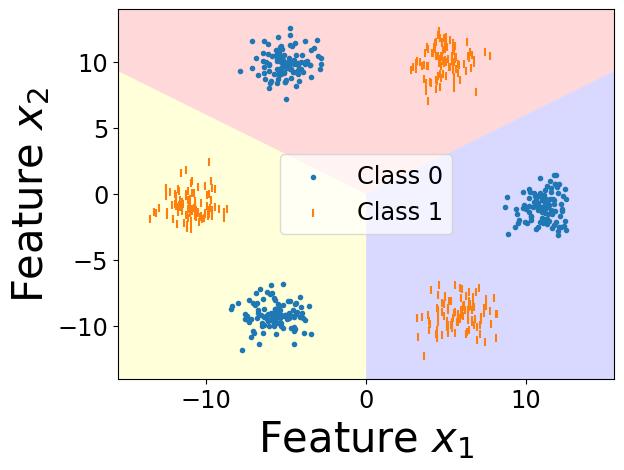

In [26]:
import matplotlib.pyplot as plt
import numpy as np
import os
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
from sklearn.datasets import make_blobs

centers = [(-5, 10), (5, 10),
           (5 * 1.67 + 2.5, -5 + 2.5 * 1.67), (5 * 1.67 - 2.5, -5 - 2.5 * 1.67), 
           (-5 * 1.67 + 2.5, -5 - 2.5 * 1.67), (-5 * 1.67 - 2.5, -5 + 2.5 * 1.67)]
n_samples_per_cluster = 100

X_0 = X_1 = np.ndarray((0, 2), dtype='float')
y_0 = y_1 = np.array([])
for i in range(3):
    X_temp_0, y_temp_0 = make_blobs(n_samples=n_samples_per_cluster, centers=centers[2 * i: 2 * i + 1], shuffle=False)
    X_0 = np.concatenate((X_0, X_temp_0))
    y_0 = np.concatenate((y_0, np.full(n_samples_per_cluster, 0)))
    X_temp_1, y_temp_1 = make_blobs(n_samples=n_samples_per_cluster, centers=centers[2 * i + 1: 2 * i + 2], shuffle=False)
    X_1 = np.concatenate((X_1, X_temp_1))
    y_1 = np.concatenate((y_1, np.full(n_samples_per_cluster, 1)))
    if i == 0:
        X_red = np.concatenate((X_temp_0, X_temp_1))
        y_red = np.concatenate((np.full(n_samples_per_cluster, 0), np.full(n_samples_per_cluster, 1)))
    elif i == 1:
        X_yellow = np.concatenate((X_temp_0, X_temp_1))
        y_yellow = np.concatenate((np.full(n_samples_per_cluster, 0), np.full(n_samples_per_cluster, 1)))
    else:
        X_blue = np.concatenate((X_temp_0, X_temp_1))
        y_blue = np.concatenate((np.full(n_samples_per_cluster, 0), np.full(n_samples_per_cluster, 1)))

fig, ax = plt.subplots()

region_red = Polygon(np.array([[0, 0], [-25, 15], [25, 15]]), closed=True)
region_yellow = Polygon(np.array([[0, 0], [-25, 15], [0, -100]]), closed=True)
region_blue = Polygon(np.array([[0, 0], [25, 15], [0, -100]]), closed=True)
patches = [region_red, region_yellow, region_blue]
p = PatchCollection(patches, alpha=0.15)
p.set(facecolor=['red', 'yellow', 'blue'])
ax.add_collection(p)

ax.scatter(X_0[:, 0], X_0[:, 1], marker='.', label='Class 0')
ax.scatter(X_1[:, 0], X_1[:, 1], marker='|', label='Class 1')

ax.set_xlabel(r'Feature $x_1$', fontsize=30)
ax.set_ylabel(r'Feature $x_2$', fontsize=30)
ax.set_xlim(left=-15.5, right=15.5)
ax.set_ylim(bottom=-14, top=14)
ax.legend(facecolor='white', framealpha=0.7, fontsize='xx-large', loc='center')
ax.tick_params(axis='both', labelsize='xx-large')

plt.show()
PATH_TO_IMAGES = "./images/data_similarity/"
if not os.path.isdir(PATH_TO_IMAGES):
    os.makedirs(PATH_TO_IMAGES)
fig.savefig(os.path.join(PATH_TO_IMAGES, "synthetic_dataset_visualization.png"), dpi=300, bbox_inches='tight')

In [5]:
from sklearn.model_selection import train_test_split

X_red_train, X_red_test, y_red_train, y_red_test = train_test_split(X_red, y_red, test_size=0.3, shuffle=True)
X_red_train, X_redd_train, y_red_train, y_redd_train = train_test_split(X_red_train, y_red_train, test_size=0.5, shuffle=True)
X_yellow_train, X_yellow_test, y_yellow_train, y_yellow_test = train_test_split(X_yellow, y_yellow, test_size=0.3, shuffle=True)
X_blue_train, X_blue_test, y_blue_train, y_blue_test = train_test_split(X_blue, y_blue, test_size=0.3, shuffle=True)
X_test = np.concatenate((X_red_test, X_yellow_test, X_blue_test))
y_test = np.concatenate((y_red_test, y_yellow_test, y_blue_test))
RED = (X_red_train, y_red_train)
REDD = (X_redd_train, y_redd_train)
YELLOW = (X_yellow_train, y_yellow_train)
BLUE = (X_blue_train, y_blue_train)

In [6]:
from urdava.data_valuation import ValuableModel
from urdava.model_utility import IClassificationModel, model_knn

data_sources = {0: RED, 1: REDD, 2: YELLOW, 3: BLUE}
model_utility_function = IClassificationModel(model_knn, data_sources, X_test, y_test)

valuable_model = ValuableModel((0, 1, 2, 3), model_utility_function)

In [22]:
from urdava.coalition_probability import IndependentCoalitionProbability

x = [[] for i in range(6)]
y = [[] for i in range(6)]

for i in range(4): # 100%, 80%, 60%, 40%, 20%, 0%:
    x[i] = [1 - 0.05 * j for j in range(21)]
    for j in range(21): # 100%, 95%, ..., 5%, 0%
        coalition_probability = IndependentCoalitionProbability({0: 1 - 0.05 * j, 1: 1 - 1/3 * i, 
                                                                 2: 1 - 1/3 * i, 3: 1 - 1/3 * i})
        y[i].append(valuable_model.valuate(data_valuation_function='012-mcmc robust banzhaf', 
                                           coalition_probability=coalition_probability, tolerance=1.0005)[0])

====> Monte-Carlo Round 0 - Average convergence rate = 0.0
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 500 - Average convergence rate = 0.9945466883852736
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 1000 - Average convergence rate = 0.9962335102054991
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 1500 - Average convergence rate = 1.0026468609819903
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 2000 - Average convergence rate = 1.0004712018574828
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 2500 - Average convergence rate = 1.0008384295441937
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 3000 - Average convergence rate = 1.0007015425656491
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 3500 - Average convergence rate = 1.0003478115924147
---------> Number 

====> Monte-Carlo Round 0 - Average convergence rate = 0.0
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 500 - Average convergence rate = 0.9901620518908401
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 1000 - Average convergence rate = 0.9985549424640778
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 1500 - Average convergence rate = 0.9996628013937062
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 2000 - Average convergence rate = 1.0033773958099366
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 2500 - Average convergence rate = 1.003295519245694
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 3000 - Average convergence rate = 1.0033971753686428
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 3500 - Average convergence rate = 1.0031354268853412
---------> Number o

====> Monte-Carlo Round 1500 - Average convergence rate = 1.0001855822712695
---------> Number of values that have not converged: 2
====> Monte-Carlo Round 2000 - Average convergence rate = 0.9992643795799508
---------> Number of values that have not converged: 2
====> Monte-Carlo Round 2500 - Average convergence rate = 0.9988617707126238
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 3000 - Average convergence rate = 0.9990411713250066
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 3500 - Average convergence rate = 0.9993849933475443
---------> Number of values that have not converged: 2
====> Monte-Carlo Round 4000 - Average convergence rate = 0.99935223504052
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 4500 - Average convergence rate = 0.9994700309900879
---------> Number of values that have not converged: 2
====> Monte-Carlo Round 0 - Average convergence rate = 0.0
---------> Number o

====> Monte-Carlo Round 5500 - Average convergence rate = 1.0003757031850071
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 6000 - Average convergence rate = 1.0000652738871305
---------> Number of values that have not converged: 1
====> Monte-Carlo Round 6500 - Average convergence rate = 1.0006525087863771
---------> Number of values that have not converged: 2
====> Monte-Carlo Round 7000 - Average convergence rate = 0.9999086306622513
---------> Number of values that have not converged: 1
====> Monte-Carlo Round 0 - Average convergence rate = 0.0
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 500 - Average convergence rate = 0.9957641159886883
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 1000 - Average convergence rate = 1.0046306955382995
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 1500 - Average convergence rate = 1.0017290825412768
---------> Number 

====> Monte-Carlo Round 3000 - Average convergence rate = 0.9986779676963096
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 3500 - Average convergence rate = 0.9991729590920829
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 4000 - Average convergence rate = 0.999199498995899
---------> Number of values that have not converged: 2
====> Monte-Carlo Round 0 - Average convergence rate = 0.0
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 500 - Average convergence rate = 0.9963941908538171
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 1000 - Average convergence rate = 0.9996352375275268
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 1500 - Average convergence rate = 0.9988020824650274
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 2000 - Average convergence rate = 0.9992861873028354
---------> Number o

====> Monte-Carlo Round 2500 - Average convergence rate = 1.0006120462333936
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 3000 - Average convergence rate = 0.999600288653612
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 3500 - Average convergence rate = 1.0002221902798354
---------> Number of values that have not converged: 2
====> Monte-Carlo Round 4000 - Average convergence rate = 1.000370454933678
---------> Number of values that have not converged: 1
====> Monte-Carlo Round 4500 - Average convergence rate = 0.9995939916777387
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 5000 - Average convergence rate = 0.9997962806279387
---------> Number of values that have not converged: 1
====> Monte-Carlo Round 5500 - Average convergence rate = 0.9996156674131422
---------> Number of values that have not converged: 1
====> Monte-Carlo Round 0 - Average convergence rate = 0.0
---------> Number o

====> Monte-Carlo Round 5500 - Average convergence rate = 1.0001792226651804
---------> Number of values that have not converged: 2
====> Monte-Carlo Round 6000 - Average convergence rate = 1.0012206843050746
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 6500 - Average convergence rate = 0.999750045599396
---------> Number of values that have not converged: 1
====> Monte-Carlo Round 7000 - Average convergence rate = 1.0004937252557933
---------> Number of values that have not converged: 2
====> Monte-Carlo Round 7500 - Average convergence rate = 1.0003011225068597
---------> Number of values that have not converged: 1
====> Monte-Carlo Round 8000 - Average convergence rate = 1.0002089047801777
---------> Number of values that have not converged: 1
====> Monte-Carlo Round 8500 - Average convergence rate = 0.9998993391227512
---------> Number of values that have not converged: 1
====> Monte-Carlo Round 9000 - Average convergence rate = 0.9997724002615337


====> Monte-Carlo Round 500 - Average convergence rate = 0.9951461186726832
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 1000 - Average convergence rate = 0.9996816408223121
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 1500 - Average convergence rate = 1.0006404513356115
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 2000 - Average convergence rate = 0.9998258121600799
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 2500 - Average convergence rate = 0.9992651838257248
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 3000 - Average convergence rate = 0.9981627108254758
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 3500 - Average convergence rate = 1.00047611539935
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 4000 - Average convergence rate = 0.999174370722584
---

====> Monte-Carlo Round 5500 - Average convergence rate = 0.999652543376748
---------> Number of values that have not converged: 2
====> Monte-Carlo Round 6000 - Average convergence rate = 1.0000572358822364
---------> Number of values that have not converged: 1
====> Monte-Carlo Round 0 - Average convergence rate = 0.0
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 500 - Average convergence rate = 0.9929108022702156
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 1000 - Average convergence rate = 0.9945858101083596
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 1500 - Average convergence rate = 0.997413258050758
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 2000 - Average convergence rate = 0.9984411998442334
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 2500 - Average convergence rate = 0.9991890717537865
---------> Number of

====> Monte-Carlo Round 7000 - Average convergence rate = 0.9996843602144025
---------> Number of values that have not converged: 1
====> Monte-Carlo Round 7500 - Average convergence rate = 1.0003466093035804
---------> Number of values that have not converged: 2
====> Monte-Carlo Round 0 - Average convergence rate = 0.0
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 500 - Average convergence rate = 0.9993543806845171
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 1000 - Average convergence rate = 0.995940406272639
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 1500 - Average convergence rate = 0.9994727667987173
---------> Number of values that have not converged: 2
====> Monte-Carlo Round 2000 - Average convergence rate = 0.9998600213557334
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 2500 - Average convergence rate = 0.9992567480015793
---------> Number o

====> Monte-Carlo Round 3500 - Average convergence rate = 1.00027239971431
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 4000 - Average convergence rate = 1.0001004045743849
---------> Number of values that have not converged: 2
====> Monte-Carlo Round 4500 - Average convergence rate = 1.0004924074416341
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 5000 - Average convergence rate = 1.0000818304589645
---------> Number of values that have not converged: 1
====> Monte-Carlo Round 5500 - Average convergence rate = 1.000414780636104
---------> Number of values that have not converged: 2
====> Monte-Carlo Round 6000 - Average convergence rate = 1.0014631062733756
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 6500 - Average convergence rate = 1.0001126047121534
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 7000 - Average convergence rate = 1.0004634301479818
--

====> Monte-Carlo Round 11500 - Average convergence rate = 1.0001949249955764
---------> Number of values that have not converged: 1
====> Monte-Carlo Round 12000 - Average convergence rate = 1.000388415805965
---------> Number of values that have not converged: 1
====> Monte-Carlo Round 0 - Average convergence rate = 0.0
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 500 - Average convergence rate = 1.0049563565264306
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 1000 - Average convergence rate = 0.999810400563301
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 1500 - Average convergence rate = 0.9993259456138809
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 2000 - Average convergence rate = 1.0005900263837224
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 2500 - Average convergence rate = 1.0004127082877743
---------> Number 

====> Monte-Carlo Round 0 - Average convergence rate = 0.0
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 500 - Average convergence rate = 0.998623783008335
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 1000 - Average convergence rate = 0.9975046057098976
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 1500 - Average convergence rate = 0.9963982956065308
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 2000 - Average convergence rate = 0.9981770820829516
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 2500 - Average convergence rate = 1.000011370922002
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 3000 - Average convergence rate = 0.9998133294832574
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 0 - Average convergence rate = 0.0
---------> Number of values that have 

====> Monte-Carlo Round 4500 - Average convergence rate = 0.9989553960742573
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 5000 - Average convergence rate = 0.9992089386706181
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 5500 - Average convergence rate = 0.999327060944505
---------> Number of values that have not converged: 2
====> Monte-Carlo Round 6000 - Average convergence rate = 0.999734621043739
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 6500 - Average convergence rate = 0.999796531737979
---------> Number of values that have not converged: 2
====> Monte-Carlo Round 7000 - Average convergence rate = 1.000137745977756
---------> Number of values that have not converged: 1
====> Monte-Carlo Round 7500 - Average convergence rate = 0.9998185499417929
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 0 - Average convergence rate = 0.0
---------> Number of 

====> Monte-Carlo Round 6000 - Average convergence rate = 0.999467728631592
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 6500 - Average convergence rate = 0.999804272779157
---------> Number of values that have not converged: 2
====> Monte-Carlo Round 7000 - Average convergence rate = 0.9996650368419608
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 0 - Average convergence rate = 0.0
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 500 - Average convergence rate = nan
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 1000 - Average convergence rate = nan
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 1500 - Average convergence rate = nan
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 2000 - Average convergence rate = nan
---------> Number of values that have not converged: 3
====> Monte-Carlo Round 2

====> Monte-Carlo Round 3000 - Average convergence rate = nan
---------> Number of values that have not converged: 1
====> Monte-Carlo Round 0 - Average convergence rate = 0.0
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 500 - Average convergence rate = nan
---------> Number of values that have not converged: 1
====> Monte-Carlo Round 1000 - Average convergence rate = nan
---------> Number of values that have not converged: 1
====> Monte-Carlo Round 1500 - Average convergence rate = nan
---------> Number of values that have not converged: 1
====> Monte-Carlo Round 2000 - Average convergence rate = nan
---------> Number of values that have not converged: 1
====> Monte-Carlo Round 2500 - Average convergence rate = nan
---------> Number of values that have not converged: 1
====> Monte-Carlo Round 0 - Average convergence rate = 0.0
---------> Number of values that have not converged: 4
====> Monte-Carlo Round 500 - Average convergence rate = nan
--------->

In [23]:
banzhaf_score = valuable_model.valuate(data_valuation_function='banzhaf')[0]

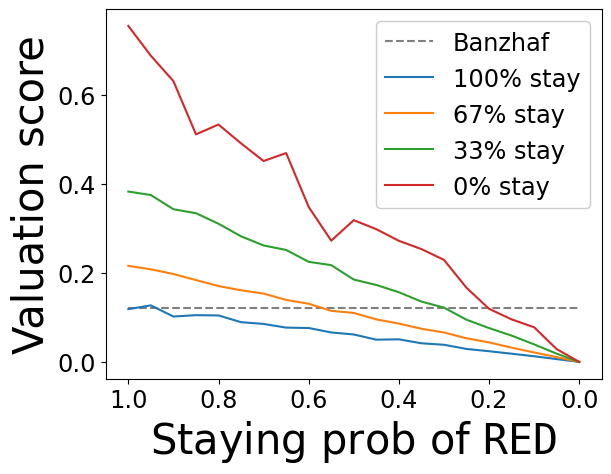

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(x[0], [banzhaf_score] * 21, linestyle='dashed', color='gray', label='Banzhaf')
for i in range(4):
    ax.plot(x[i], y[i], color='C' + str(i), label=f'{round((1 - 1/3 * i)*100)}% stay')
    
ax.set_xlabel(r'Staying prob of $\mathtt{RED}$', fontsize=30)
ax.set_ylabel('Valuation score', fontsize=30)
ax.legend(facecolor='white', framealpha=1, fontsize='xx-large', loc='upper right')
ax.tick_params(axis='both', labelsize='xx-large')
plt.gca().invert_xaxis()
PATH_TO_IMAGES = "./images/data_similarity/"
if not os.path.isdir(PATH_TO_IMAGES):
    os.makedirs(PATH_TO_IMAGES)
fig.savefig(os.path.join(PATH_TO_IMAGES, "synthetic_dataset_result.png"), dpi=300, bbox_inches='tight')